In [422]:
import dataLoader as loader
import HDDMmodelMaker as ddm
import pandas as pd
import time
import matplotlib.pyplot as plt
import hddm
import random
import scipy.stats as st
import numpy as np
import seaborn as sns
import pymc as mc
import random 

In [197]:
data = hddm.load_csv('./raw data/output_data.dat')
session = data["player"].str.split("_", n=1, expand=True)
data["session"] = session[0]
data["treatment"] = ""
data.loc[data["session"].isin(['s1m5', 's2m5', 's4m8', 's8n3', 's9n3', 's10n5']), 'treatment'] = "fix"
data.loc[data["session"].isin(['s5m20', 's6m22', 's7m22', 's11n9', 's12n11', 's13n12']), 'treatment'] = "changing"
data.loc[data["session"].isin(['s3m7']), 'treatment'] = "weak"
data.head()

,round,player,action_player,opponent,action_opponent,payoff,time_php,time_js,who_played,session,treatment
0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,4480.199814,4452,user,s3m7,weak
1,1,s3m7_usuario18,C,['s3m7_usuario9'],D,0,9472.300053,9443,user,s3m7,weak
2,1,s3m7_usuario7,C,['s3m7_usuario10'],C,3,2238.199949,2213,user,s3m7,weak
3,1,s3m7_usuario10,C,['s3m7_usuario7'],C,3,8133.699894,8101,user,s3m7,weak
4,1,s3m7_usuario13,C,['s3m7_usuario5'],C,3,5098.500013,5043,user,s3m7,weak


In [198]:
#Import data_actions.csv from now on, time intensive
data["actions"] = ""
nrounds = data["round"].unique()
players = data.player.unique()
for r in nrounds:
    for p in players:
        action1 = ""
        if r == 1: action1 = "00"
        else:
            action1 = "%s%s" % (data.loc[(data["round"] == r-1) & (data["player"] == p), "action_player"].item(),
                                data.loc[(data["round"] == r-1) & (data["player"] == p), "action_opponent"].item())
        data.loc[(data["round"] == r) & (data["player"] == p), ['actions']] = "%s%s" % (action1, data.loc[(data["round"] == r) & (data["player"] == p), "action_player"].item())
data.to_csv("data_actions.csv")

In [199]:
#Some more format, ignore and import data_actions.csv from now on
data = hddm.load_csv("data_actions.csv")

del data["who_played"], data["time_php"]
data.rename(columns={'time_js': 'rt'}, inplace=True)
data['rt'] = data.rt.astype(int)
data["response"] = data["action_player"]
data.loc[data['response'] == "C", "response"] = 1.0
data.loc[data['response'] == "D", "response"] = 0.0
data["rt"] = data["rt"] / 1000
data = hddm.utils.flip_errors(data)
data["abs_time"] = data["rt"].abs()
del data["Unnamed: 0"]


data.to_csv("data_actions.csv")

In [200]:
data = hddm.load_csv("data_actions.csv")


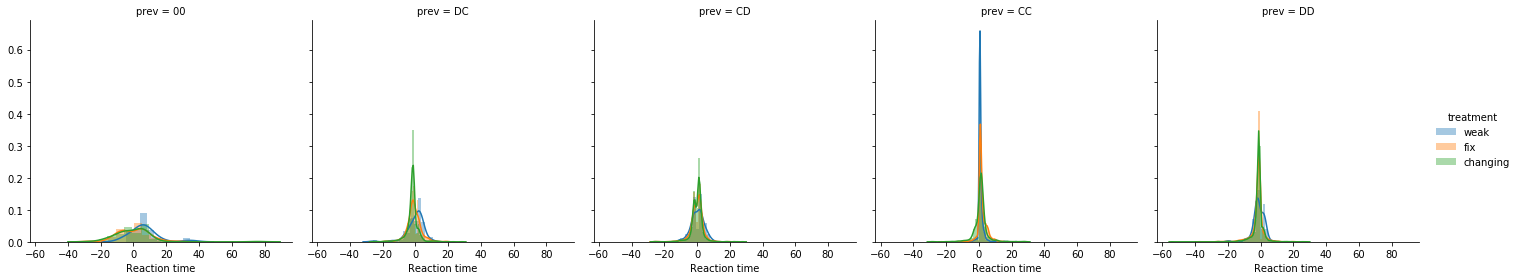

In [201]:
data["prev"] = data.actions.str[:2]
g = sns.FacetGrid(data, col="prev", hue = "treatment", height = 4)
g.map(sns.distplot, "rt")
g.add_legend()
g.set(xlabel = "Reaction time")

In [202]:
def actionChange(actions1, actions2, user1, user2, rt):
    if len(actions1) != len(actions2): return "Lenghts mismatch" #Raise exception
    rounds = len(actions1)
    prev1 = ""
    prev2 = ""
    switch_events = pd.DataFrame(columns=["type", "lag", "subject", "round", "rt"])
    lag = 0
    for r in range(0, rounds):
        if r ==0:
            prev1 = actions1[r]
            prev2 = actions2[r]
            lag += 1
            continue
        elif actions1[r] != prev1:
            switch_events = switch_events.append(
                {"context": prev2, "type": "%s%s" % (prev1, actions1[r]),
                 "lag": lag, "subject": user1, "round": r + 1, "rt": rt[r]}, ignore_index=True)
            lag = 0
        if actions2[r] == prev2:
            lag += 1
        else: lag = 1
        prev1 = actions1[r]
        prev2 = actions2[r]
    return switch_events

In [203]:
def actionCounts(actions, user):
    prosocial = ['CCC', 'CDC', '00C', 'DDC', 'DCC']
    proself = ['DDD', 'DCD', '00D', 'CCD', 'CDD']
    rating = 0
    act_df = {'user':user,'00D':0,'00C':0,'DCD':0,'CDC':0,'CCC':0,'CDD':0,'CCD':0,'DDC':0,'DCC':0,'DDD':0, 'type':""}
    for a in actions:
        act_df[a] = act_df[a] + 1
        if a in prosocial:
            rating = rating + 1
        else: rating = rating - 1
    if rating >= 0: act_df["type"] = "Pro-social"
    else: act_df["type"] = "Pro-self"
    return act_df

In [204]:
switches = pd.DataFrame()
actions = pd.DataFrame()
for t in data.treatment.unique():
    t_df = data.loc[(data.treatment == t)]
    users = t_df.player.unique()
    switchesT = pd.DataFrame()
    actionsT = pd.DataFrame()
    for u in users:
        df = t_df.loc[t_df.player == u]
        df = df.sort_values(by = "round", ascending = True)
        opp = str(df.opponent.unique())
        acc1 = df.action_player.values
        acc2 = df.action_opponent.values
        rt = df["rt"].values
        switchesT = switchesT.append(actionChange(acc1, acc2, u, opp, rt))
        actionsT = actionsT.append(actionCounts(df.actions, u), ignore_index=True)
    switchesT["treatment"] = t
    actionsT["treatment"] = t
    switches = switches.append(switchesT, ignore_index = True)
    actions = actions.append(actionsT, ignore_index = True)

In [205]:
switches

,context,lag,round,rt,subject,type,treatment
0,C,1,2,5.401,s3m7_usuario9,DC,weak
1,C,1,3,-10.751,s3m7_usuario9,CD,weak
2,C,1,4,3.443,s3m7_usuario9,DC,weak
3,C,2,6,-5.265,s3m7_usuario9,CD,weak
4,C,1,7,5.641,s3m7_usuario9,DC,weak
5,D,1,8,-10.555,s3m7_usuario9,CD,weak
6,C,1,9,10.590,s3m7_usuario9,DC,weak
7,C,1,10,-7.549,s3m7_usuario9,CD,weak
8,D,1,11,2.952,s3m7_usuario9,DC,weak
9,C,1,14,-1.764,s3m7_usuario9,CD,weak


In [206]:
actions

,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak
5,1.0,0.0,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario5,weak
6,0.0,1.0,93.0,0.0,1.0,0.0,0.0,1.0,1.0,3.0,Pro-social,s3m7_usuario15,weak
7,1.0,0.0,93.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,Pro-social,s3m7_usuario16,weak
8,0.0,1.0,86.0,2.0,1.0,1.0,3.0,3.0,1.0,2.0,Pro-social,s3m7_usuario12,weak
9,1.0,0.0,88.0,0.0,3.0,3.0,1.0,1.0,2.0,1.0,Pro-social,s3m7_usuario6,weak


In [207]:
data_svo = pd.merge(data, actions[["type", "user"]], left_on = "player", right_on = "user")
data_svo

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
0,0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-4.452,s3m7,weak,00D,0,4.452,00,Pro-social,s3m7_usuario9
1,18,2,s3m7_usuario9,C,['s3m7_usuario18'],C,3,5.401,s3m7,weak,DCC,1,5.401,DC,Pro-social,s3m7_usuario9
2,36,3,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-10.751,s3m7,weak,CCD,0,10.751,CC,Pro-social,s3m7_usuario9
3,54,4,s3m7_usuario9,C,['s3m7_usuario18'],C,3,3.443,s3m7,weak,DCC,1,3.443,DC,Pro-social,s3m7_usuario9
4,72,5,s3m7_usuario9,C,['s3m7_usuario18'],C,3,6.401,s3m7,weak,CCC,1,6.401,CC,Pro-social,s3m7_usuario9
5,90,6,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-5.265,s3m7,weak,CCD,0,5.265,CC,Pro-social,s3m7_usuario9
6,108,7,s3m7_usuario9,C,['s3m7_usuario18'],D,0,5.641,s3m7,weak,DCC,1,5.641,DC,Pro-social,s3m7_usuario9
7,126,8,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-10.555,s3m7,weak,CDD,0,10.555,CD,Pro-social,s3m7_usuario9
8,144,9,s3m7_usuario9,C,['s3m7_usuario18'],C,3,10.590,s3m7,weak,DCC,1,10.590,DC,Pro-social,s3m7_usuario9
9,162,10,s3m7_usuario9,D,['s3m7_usuario18'],D,0,-7.549,s3m7,weak,CCD,0,7.549,CC,Pro-social,s3m7_usuario9


In [208]:
display(data_svo.head())
display(actions.head())

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
0,0,1,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-4.452,s3m7,weak,00D,0,4.452,00,Pro-social,s3m7_usuario9
1,18,2,s3m7_usuario9,C,['s3m7_usuario18'],C,3,5.401,s3m7,weak,DCC,1,5.401,DC,Pro-social,s3m7_usuario9
2,36,3,s3m7_usuario9,D,['s3m7_usuario18'],C,4,-10.751,s3m7,weak,CCD,0,10.751,CC,Pro-social,s3m7_usuario9
3,54,4,s3m7_usuario9,C,['s3m7_usuario18'],C,3,3.443,s3m7,weak,DCC,1,3.443,DC,Pro-social,s3m7_usuario9
4,72,5,s3m7_usuario9,C,['s3m7_usuario18'],C,3,6.401,s3m7,weak,CCC,1,6.401,CC,Pro-social,s3m7_usuario9


,00C,00D,CCC,CCD,CDC,CDD,DCC,DCD,DDC,DDD,type,user,treatment
0,0.0,1.0,69.0,9.0,1.0,2.0,9.0,1.0,3.0,5.0,Pro-social,s3m7_usuario9,weak
1,1.0,0.0,74.0,4.0,9.0,1.0,2.0,1.0,3.0,5.0,Pro-social,s3m7_usuario18,weak
2,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario7,weak
3,1.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Pro-social,s3m7_usuario10,weak
4,1.0,0.0,97.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,Pro-social,s3m7_usuario13,weak


In [209]:
actions.loc[actions.treatment == "weak", "type"].value_counts()

Pro-social    18
Name: type, dtype: int64

In [210]:
data.payoff.unique()

array([4, 0, 3, 1])

In [211]:
## Checking how many rows are there per context
fix = data_svo[data_svo.treatment == "fix"]
for a in fix.actions.unique():
    for t in fix["type"].unique():
        df = fix.loc[(fix.actions == a) & (fix["type"] == t)]
        print("%s %s %d" % (a, t, len(df.index)))

00D Pro-social 14
00D Pro-self 13
DCD Pro-social 111
DCD Pro-self 284
DCC Pro-social 124
DCC Pro-self 92
CDD Pro-social 129
CDD Pro-self 134
DDC Pro-social 94
DDC Pro-self 117
CCC Pro-social 2387
CCC Pro-self 155
00C Pro-social 20
00C Pro-self 11
CDC Pro-social 270
CDC Pro-self 78
DDD Pro-social 175
DDD Pro-self 1438
CCD Pro-social 76
CCD Pro-self 78


In [212]:
## Checking how many rows are there per context
fix = data_svo[data_svo.treatment == "fix"]
fix

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
1800,1800,1,s4m8_usuario2,D,['s4m8_usuario7'],C,4,-4.600,s4m8,fix,00D,0,4.600,00,Pro-social,s4m8_usuario2
1801,1814,2,s4m8_usuario2,D,['s4m8_usuario7'],C,4,-6.756,s4m8,fix,DCD,0,6.756,DC,Pro-social,s4m8_usuario2
1802,1828,3,s4m8_usuario2,C,['s4m8_usuario7'],D,0,8.987,s4m8,fix,DCC,1,8.987,DC,Pro-social,s4m8_usuario2
1803,1842,4,s4m8_usuario2,D,['s4m8_usuario7'],D,1,-5.750,s4m8,fix,CDD,0,5.750,CD,Pro-social,s4m8_usuario2
1804,1856,5,s4m8_usuario2,C,['s4m8_usuario7'],C,3,10.820,s4m8,fix,DDC,1,10.820,DD,Pro-social,s4m8_usuario2
1805,1870,6,s4m8_usuario2,C,['s4m8_usuario7'],C,3,6.138,s4m8,fix,CCC,1,6.138,CC,Pro-social,s4m8_usuario2
1806,1884,7,s4m8_usuario2,C,['s4m8_usuario7'],C,3,3.556,s4m8,fix,CCC,1,3.556,CC,Pro-social,s4m8_usuario2
1807,1898,8,s4m8_usuario2,C,['s4m8_usuario7'],C,3,1.599,s4m8,fix,CCC,1,1.599,CC,Pro-social,s4m8_usuario2
1808,1912,9,s4m8_usuario2,C,['s4m8_usuario7'],C,3,1.419,s4m8,fix,CCC,1,1.419,CC,Pro-social,s4m8_usuario2
1809,1926,10,s4m8_usuario2,C,['s4m8_usuario7'],C,3,1.636,s4m8,fix,CCC,1,1.636,CC,Pro-social,s4m8_usuario2


In [86]:
actions_list = ['DCD', 'DCC', 'CDD', 'DDC', 'CCC', 'CDC', 'DDD',
       'CCD']
modeler = ddm.HDDMmodelMaker()
st = time.time()
contextDf = pd.DataFrame()
window = 10
for a in actions_list:
    df = fix.loc[fix["actions"]==a]
    try:
        model = modeler.fit_model(df, 5000, 200)
        print("\nModel: %s, time: %f\n" % (a, time.time() - st))
        modStats = modeler.get_stats(model, subjects = True)
        modStats["actions"] = a
        contextDf = contextDf.append(modStats, ignore_index = True)
    except: break
    contextDf.to_csv("./outputs/%s_svo.csv" % (a))

 [-----------------100%-----------------] 5000 of 5000 complete in 24.7 sec
Model: DCD, time: 25.025319

 [-----------------100%-----------------] 5000 of 5000 complete in 32.7 sec
Model: DCC, time: 58.254206

 [-----------------100%-----------------] 5000 of 5000 complete in 22.5 sec
Model: CDD, time: 81.290827

 [-----------------100%-----------------] 5000 of 5000 complete in 22.7 sec
Model: DDC, time: 104.502801

 [-----------------100%-----------------] 5000 of 5000 complete in 65.7 sec
Model: CCC, time: 170.643716

 [-----------------100%-----------------] 5000 of 5000 complete in 24.4 sec
Model: CDC, time: 195.538278

 [-----------------100%-----------------] 5000 of 5000 complete in 45.7 sec
Model: DDD, time: 241.832812

 [-----------------100%-----------------] 5000 of 5000 complete in 21.9 sec
Model: CCD, time: 264.213755



In [87]:
contextDf

,mean,std,2.5q,25q,50q,75q,97.5q,mc err,param,subject,actions
0,2.78149,0.636902,1.30431,2.40825,2.92142,3.2103,3.83394,0.0148882,a,None,DCD
1,0.943849,0.690711,0.152392,0.425312,0.769667,1.27452,2.70579,0.021255,a_std,None,DCD
2,3.42658,0.110023,3.20281,3.35521,3.42676,3.50191,3.64033,0.00325328,a,Pro-self,DCD
3,2.99187,0.119386,2.76221,2.91169,2.98856,3.07041,3.23659,0.00442004,a,Pro-social,DCD
4,0.273134,0.97273,-1.52644,-0.233118,0.18584,0.674335,2.57073,0.0156791,v,None,DCD
5,1.29754,0.872921,0.301945,0.643331,1.05701,1.7083,3.53281,0.0231695,v_std,None,DCD
6,-0.342891,0.0525969,-0.44556,-0.378507,-0.342825,-0.308125,-0.237774,0.00128307,v,Pro-self,DCD
7,0.477546,0.0638167,0.351713,0.434664,0.47804,0.519138,0.603346,0.00215351,v,Pro-social,DCD
8,0.353415,0.164179,0.103181,0.231416,0.330648,0.453376,0.734344,0.00546435,t,None,DCD
9,0.744459,0.478925,0.066654,0.378861,0.670574,1.02537,1.87034,0.0210491,t_std,None,DCD


In [88]:
actions_list = ['DCD', 'DCC', 'CDD', 'DDC', 'CCC', 'CDC', 'DDD',
       'CCD']
modeler = ddm.HDDMmodelMaker()
st = time.time()
contextDfMin = pd.DataFrame()
for a in actions_list:
    df = fix.loc[fix["actions"]==a]
    df = df.sample(n = 76, random_state = 1)
    try:
        model = modeler.fit_model(df, 5000, 200)
        print("\nModel: %s, time: %f\n" % (a, time.time() - st))
        modStats = modeler.get_stats(model, subjects = True)
        modStats["actions"] = a
        contextDfMin = contextDfMin.append(modStats, ignore_index = True)
    except: break
    #contextDf.to_csv("./outputs/%s_svo.csv" % (a))

 [-----------------100%-----------------] 5000 of 5000 complete in 21.7 sec
Model: DCD, time: 22.104858

 [-----------------100%-----------------] 5000 of 5000 complete in 23.4 sec
Model: DCC, time: 46.017219

 [-----------------100%-----------------] 5000 of 5000 complete in 19.9 sec
Model: CDD, time: 66.373445

 [-----------------100%-----------------] 5000 of 5000 complete in 28.0 sec
Model: DDC, time: 94.826553

 [-----------------100%-----------------] 5000 of 5000 complete in 22.3 sec
Model: CCC, time: 117.581413

 [-----------------100%-----------------] 5000 of 5000 complete in 19.0 sec
Model: CDC, time: 137.009129

 [-----------------100%-----------------] 5000 of 5000 complete in 19.2 sec
Model: DDD, time: 156.663102

 [-----------------100%-----------------] 5000 of 5000 complete in 19.2 sec
Model: CCD, time: 176.402502



In [92]:
contextDfMin.loc[contextDfMin.subject== "Pro-self", ["mean", "param", "actions"]]

,mean,param,actions
2,3.1689,a,DCD
6,-0.32257,v,DCD
10,0.0422914,t,DCD
14,0.521914,z,DCD
18,3.24892,a,DCC
22,-0.257053,v,DCC
26,0.0124248,t,DCC
30,0.474402,z,DCC
34,3.40943,a,CDD
38,-0.474713,v,CDD


In [402]:
df1 = fix.loc[(fix["prev"]=="CC")]
df2 = fix.loc[(fix["prev"]=="CD")]

display(df1.response.value_counts())
display(df2.response.value_counts())

1    2542
0     154
Name: response, dtype: int64

1    348
0    263
Name: response, dtype: int64

In [403]:
model = modeler.fit_model(df, 5000, 200)
model2 = modeler.fit_model(df2, 5000, 200)

 [-----------------100%-----------------] 5000 of 5000 complete in 14.0 sec

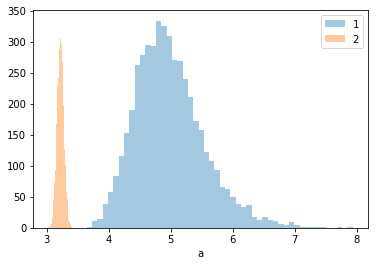

In [409]:
sns.distplot(model.get_traces()["a"], kde=False, label = "1")
sns.distplot(model2.get_traces()["a"], kde=False, label = "2")
plt.legend()

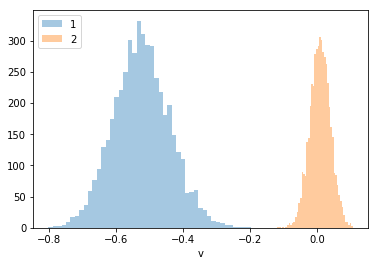

In [410]:
sns.distplot(model.get_traces()["v"], kde=False, label = "1")
sns.distplot(model2.get_traces()["v"], kde=False, label = "2")

plt.legend()

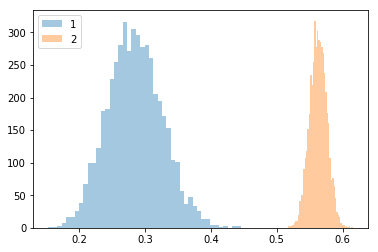

In [411]:
z_trans = model.get_traces()["z_trans"]
z_trans2 = model2.get_traces()["z_trans"]
sns.distplot(mc.invlogit(z_trans), kde=False, label = "1")
sns.distplot(mc.invlogit(z_trans2), kde=False, label = "2")
plt.legend()

In [407]:
model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,4.98214,0.558383,4.06425,4.58708,4.9166,5.29717,6.27087,0.0196003
v,-0.523112,0.0842134,-0.684327,-0.579182,-0.524829,-0.468372,-0.353031,0.00186223
t,0.189599,0.0596259,0.0760773,0.147005,0.190608,0.232644,0.302322,0.00152547
z,0.284876,0.0412573,0.208549,0.256004,0.284023,0.312247,0.369679,0.00147288


In [408]:
model2.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,3.22015,0.0534623,3.11499,3.18351,3.2201,3.25667,3.32662,0.00096914
v,0.00814125,0.030469,-0.051324,-0.0122024,0.00840306,0.0285707,0.0688024,0.000583677
t,0.037139,0.0123026,0.0140606,0.0282447,0.0369251,0.0458653,0.0610462,0.000206687
z,0.56286,0.0131354,0.537149,0.553908,0.562843,0.571804,0.588444,0.000266174


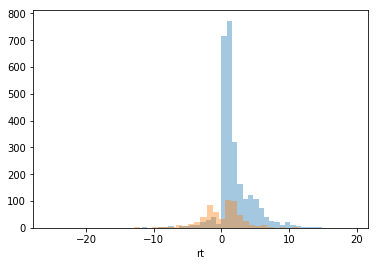

In [413]:
sns.distplot(df1.rt, kde=False, label = "1")
sns.distplot(df2.rt, kde=False, label = "2")

In [432]:
# Split fix experiment players
subjects_fix = list(fix.player.unique())
sample_subj = random.sample(subjects_fix, int(np.round(len(subjects_fix) * 0.7)))

In [436]:
train_fix = fix.loc[fix.player.isin(sample_subj)]
test_fix = fix.loc[~fix.player.isin(sample_subj)]
train_fix.shape

(4100, 16)

In [448]:
actions_list = ['DC', 'CD', 'DD', 'CC']
svo = ["Pro-social", "Pro-self"]
modeler = ddm.HDDMmodelMaker()
st = time.time()
for a in actions_list:
    for s in svo:
        df = train_fix.loc[(train_fix["prev"]==a) & (train_fix["type"]==s)]
        try:
            model = modeler.fit_model(df, 5000, 200)
            print("\nModel: %s, time: %f\n" % (a, time.time() - st))
            model.get_traces().to_csv("./outputs/%s_%s_svo.csv" % (a, s))
        except: break

 [-----------------100%-----------------] 5000 of 5000 complete in 8.0 sec
Model: DC, time: 8.140740

 [-----------------100%-----------------] 5000 of 5000 complete in 7.8 sec
Model: DC, time: 16.031399

 [-----------------100%-----------------] 5000 of 5000 complete in 9.1 sec
Model: CD, time: 25.244461

 [-----------------100%-----------------] 5000 of 5000 complete in 7.0 sec
Model: CD, time: 32.373537

 [-----------------100%-----------------] 5000 of 5000 complete in 7.7 sec
Model: DD, time: 40.208116

 [-----------------100%-----------------] 5000 of 5000 complete in 20.9 sec
Model: DD, time: 61.202157

 [-----------------100%-----------------] 5000 of 5000 complete in 36.2 sec
Model: CC, time: 97.469286

 [-----------------100%-----------------] 5000 of 5000 complete in 6.1 sec
Model: CC, time: 103.715371



In [440]:
def print_traces (context, svo,param):
    df = pd.read_csv("./outputs/%s_%s_svo.csv" % (context, svo))
    return df[param]

In [450]:
actions_list = ['DC', 'CD', 'DD', 'CC']
for u in test_fix.player.unique():
    for a in actions_list:
        df = test_fix.loc[(test_fix["prev"]==a) & (test_fix["player"]==u)]
        print("\nModel: %s, Rows: %d, time: %f\n" % (a, len(df.index), time.time() - st))
        try:
            model = modeler.fit_model(df, 5000, 200)
            model.gen_stats().to_csv("./outputs/%s_%s.csv" % (a, u))
        except: break


Model: DC, Rows: 1, time: 412.633850

 [-----------------100%-----------------] 5000 of 5000 complete in 10.6 sec
Model: CD, Rows: 2, time: 423.339301

 [-----------------100%-----------------] 5000 of 5000 complete in 10.9 sec
Model: DD, Rows: 1, time: 434.330640

 [-----------------100%-----------------] 5000 of 5000 complete in 10.0 sec
Model: CC, Rows: 95, time: 444.412292

 [-----------------100%-----------------] 5000 of 5000 complete in 4.5 sec
Model: DC, Rows: 0, time: 448.978474


Model: DC, Rows: 2, time: 448.980461

 [-----------------100%-----------------] 5000 of 5000 complete in 10.3 sec
Model: CD, Rows: 6, time: 459.405307

 [-----------------100%-----------------] 5000 of 5000 complete in 7.1 sec
Model: DD, Rows: 91, time: 466.638837

 [-----------------100%-----------------] 5000 of 5000 complete in 4.4 sec
Model: CC, Rows: 0, time: 471.191046


Model: DC, Rows: 15, time: 471.193294

 [-----------------100%-----------------] 5000 of 5000 complete in 5.3 sec
Model: CD,

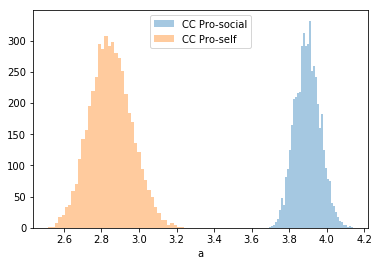

In [455]:
sns.distplot(print_traces("CC", "Pro-social", "a"), kde=False, label = "CC Pro-social")
sns.distplot(print_traces("CC", "Pro-self", "a"), kde=False, label = "CC Pro-self")
plt.legend()




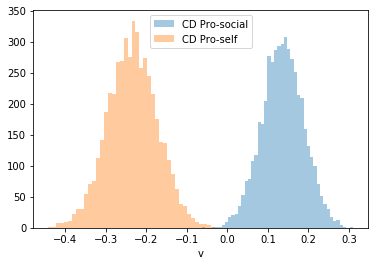

In [463]:
sns.distplot(print_traces("CD", "Pro-social", "v"), kde=False, label = "CD Pro-social")
sns.distplot(print_traces("CD", "Pro-self", "v"), kde=False, label = "CD Pro-self")
plt.legend()

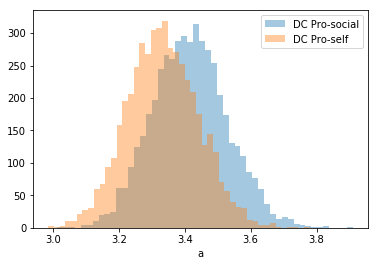

In [445]:
sns.distplot(print_traces("DC", "Pro-social", "a"), kde=False, label = "DC Pro-social")
sns.distplot(print_traces("DC", "Pro-self", "a"), kde=False, label = "DC Pro-self")
plt.legend()

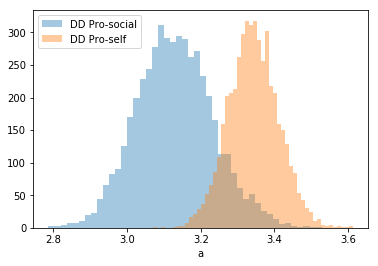

In [459]:
sns.distplot(print_traces("DD", "Pro-social", "a"), kde=False, label = "DD Pro-social")
sns.distplot(print_traces("DD", "Pro-self", "a"), kde=False, label = "DD Pro-self")
plt.legend()

In [460]:
d = pd.read_csv("./outputs/CD_s4m8_usuario7.csv")
d

,Unnamed: 0,mean,std,2.5q,25q,50q,75q,97.5q,mc err
0,a,2.663140,0.599922,1.729984,2.236563,2.591605,3.001044,4.034053,0.010519
1,v,0.062352,0.494726,-0.933714,-0.270412,0.062589,0.407072,1.034914,0.007506
2,t,0.496169,0.249820,0.131288,0.313595,0.458445,0.634185,1.100358,0.004877
3,z,0.487899,0.108562,0.283327,0.408963,0.486067,0.564928,0.698364,0.001538


In [454]:
test_fix

,Unnamed: 0,round,player,action_player,opponent,action_opponent,payoff,rt,session,treatment,actions,response,abs_time,prev,type,user
1900,1801,1,s4m8_usuario7,C,['s4m8_usuario2'],D,0,4.055,s4m8,fix,00C,1,4.055,00,Pro-social,s4m8_usuario7
1901,1815,2,s4m8_usuario7,C,['s4m8_usuario2'],D,0,3.541,s4m8,fix,CDC,1,3.541,CD,Pro-social,s4m8_usuario7
1902,1829,3,s4m8_usuario7,D,['s4m8_usuario2'],C,4,-1.953,s4m8,fix,CDD,0,1.953,CD,Pro-social,s4m8_usuario7
1903,1843,4,s4m8_usuario7,D,['s4m8_usuario2'],D,1,-2.379,s4m8,fix,DCD,0,2.379,DC,Pro-social,s4m8_usuario7
1904,1857,5,s4m8_usuario7,C,['s4m8_usuario2'],C,3,5.972,s4m8,fix,DDC,1,5.972,DD,Pro-social,s4m8_usuario7
1905,1871,6,s4m8_usuario7,C,['s4m8_usuario2'],C,3,2.077,s4m8,fix,CCC,1,2.077,CC,Pro-social,s4m8_usuario7
1906,1885,7,s4m8_usuario7,C,['s4m8_usuario2'],C,3,1.562,s4m8,fix,CCC,1,1.562,CC,Pro-social,s4m8_usuario7
1907,1899,8,s4m8_usuario7,C,['s4m8_usuario2'],C,3,1.226,s4m8,fix,CCC,1,1.226,CC,Pro-social,s4m8_usuario7
1908,1913,9,s4m8_usuario7,C,['s4m8_usuario2'],C,3,1.026,s4m8,fix,CCC,1,1.026,CC,Pro-social,s4m8_usuario7
1909,1927,10,s4m8_usuario7,C,['s4m8_usuario2'],C,3,2.281,s4m8,fix,CCC,1,2.281,CC,Pro-social,s4m8_usuario7
